In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import math
import aesara.tensor as at
import seaborn as sb
import matplotlib
import pickle

In [3]:
train_data = pd.read_csv(
    "../data_acquisition/data_0.3/training_standardized.csv", sep=";"
)

features = np.swapaxes(
    np.array(
        [
            train_data["home_xG"],
            train_data["away_xg_against"],
            train_data["away_xG"],
            train_data["home_xg_against"],
            train_data["home_xT_all"],
            train_data["away_xt_all_against"],
            train_data["away_xT_all"],
            train_data["home_xt_all_against"],
        ]
    ),
    0,
    1,
)
form = np.swapaxes(
    np.array(
        [
            (train_data["ha_form_home_for"]),
            (train_data["ha_form_home_against"]),
            (train_data["ha_form_away_for"]),
            (train_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(
    np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
)

elo_diff = np.swapaxes(
    np.array([(train_data["elo_diff_home"]), (train_data["elo_diff_away"])]), 0, 1
)

In [4]:
with pm.Model() as independent_poisson:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
    pm_goals = pm.Data("pm_goals", goals, mutable=True)
    pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

    coefs_features = pm.Normal(
        "coefs_features",
        shape=(features.shape[1], 2),
    )

    coefs_elo_diff = pm.Normal(
        "coefs_elo_diff",
        shape=(elo_diff.shape[1], 2)
    )

    coefs_form_diff = pm.Normal(
        "coefs_form_diff", shape=(form.shape[1], 2)
    )  
    intercepts = pm.Normal("intercepts", shape=2)

    log_lam = pm.Deterministic(
        "log_lam",
        intercepts
        + (pm_elo_diff @ coefs_elo_diff)
        + (pm_form_diff @ coefs_form_diff)
        + (pm_features @ coefs_features),
    )


    lam = pm.math.exp(log_lam)

    obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [5]:
N = train_data.shape[0]
K = 2
M = 10

with pm.Model() as dependent_normal_1:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)
    pm_goals = pm.Data("pm_goals", goals, mutable=True)
    pm_elo_diff = pm.Data("pm_elo_diff", elo_diff, mutable=True)

    cov_diag = pm.HalfNormal("cov_diag", shape=K)
    cov_root = pm.Normal("cov_root", shape=(M, K))
    cov = pm.Deterministic("cov", cov_root.T @ cov_root + at.diag(cov_diag))

    coefs_features = pm.HalfNormal(
        "coefs_features",  # mu=[[1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]],
        sigma=[
            [1, 0.001],
            [1, 0.001],
            [0.001, 1],
            [0.001, 1],
            [1, 0.001],
            [1, 0.001],
            [0.001, 1],
            [0.001, 1],
        ],
        shape=(features.shape[1], 2),
    )

    coefs_elo_diff = pm.Normal(
        "coefs_elo_diff", mu=[0.5, -0.5], sigma=[0.2, 0.2], shape=(1, 2)
    )

    coefs_form_diff = pm.Normal(
        "coefs_form_diff", shape=(form.shape[1], 2)
    )
    factor = pm.Dirichlet("factor", a=np.ones(3))
    intercepts = pm.Normal("intercepts", shape=2)

    log_lam = pm.MvNormal(
        "log_lam",
        intercepts
        + 0.1 * (pm_elo_diff @ coefs_elo_diff)
        + 0.4 * (pm_form_diff @ coefs_form_diff)
        + 0.5 * (pm_features @ coefs_features),
        cov=cov,
        shape=(K),
    )

    lam = pm.math.exp(log_lam)

    obs = pm.Poisson("obs", mu=lam, observed=pm_goals)

In [6]:
with pm.Model() as dependent_normal_2:
    pm_features = pm.Data("pm_features", features, mutable=True)
    pm_form_diff = pm.Data("pm_form_diff", form, mutable=True)

    sd_dist = pm.HalfNormal.dist(shape=2)
    chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=2, sd_dist=sd_dist, compute_corr=True)

    coefs = pm.Normal('coefs', shape=(features.shape[1], 2))
    coefs_form = pm.Normal('coefs_form', shape=(form.shape[1], 2))

    intercepts = pm.Normal('intercepts', shape=2)
    log_lam = pm.MvNormal('log_lam', mu=intercepts + (pm_features @ coefs) +
                                                     (pm_form_diff @ coefs_form), chol=chol, shape=(2))
    lam = pm.math.exp(log_lam)
    obs = pm.Poisson('obs', mu=lam, observed=goals)

In [7]:
MODEL = independent_poisson
# MODEL = dependent_normal_1
# MODEL = dependent_normal_2

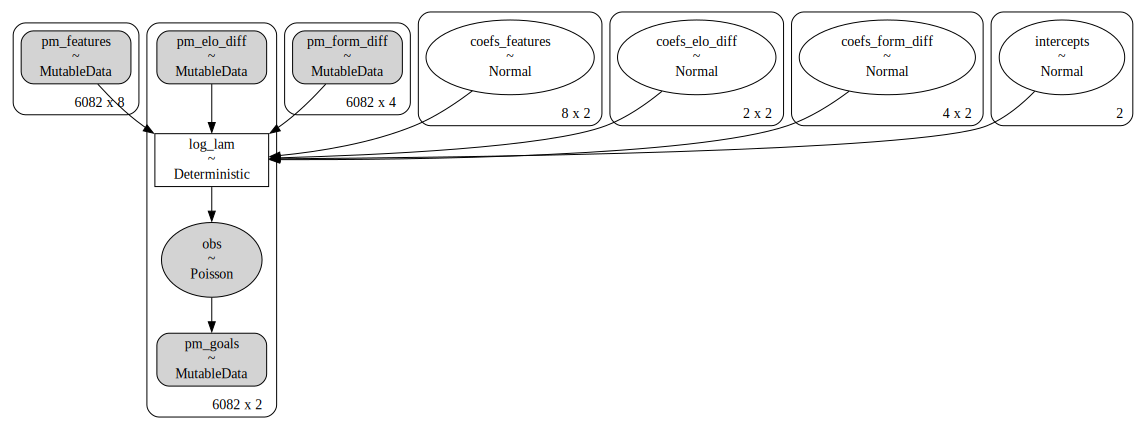

In [8]:
pm.model_to_graphviz(MODEL)

In [ ]:
TRAIN_MODEL = False

In [9]:
if TRAIN_MODEL:
    with MODEL:
        app = pm.fit(50000, progressbar=True)
        trace = app.sample(1000)
        if False:
            trace.to_netcdf("models/independent_trace.nc")
else:
    trace = az.from_netcdf("../models/independent_trace.nc").load()

Finished [100%]: Average Loss = 16,391


# Test

In [11]:
test_data = pd.read_csv(
    "../data_acquisition/data_0.3/test_standardized.csv", sep=";"
).dropna()


test_data_orig_size = test_data.shape[0]
size_diff = train_data.shape[0] - test_data.shape[0]
column_size = test_data.shape[1]
fill_data = [np.ones(column_size) for _ in range(size_diff)]
test_data_fill = pd.DataFrame(data=fill_data, columns=test_data.columns)
test_data = pd.concat([test_data, test_data_fill])

features = np.swapaxes(
    np.array(
        [
            test_data["home_xG"],
            test_data["away_xg_against"],
            test_data["away_xG"],
            test_data["home_xg_against"],
            test_data["home_xT_all"],
            test_data["away_xT_all"],
            test_data["home_xt_all_against"],
            test_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (test_data["ha_form_home_for"]),
            (test_data["ha_form_home_against"]),
            (test_data["ha_form_away_for"]),
            (test_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(
    np.array([(test_data["elo_diff_home"]), (test_data["elo_diff_away"])]), 0, 1
)

with MODEL:
    pm.set_data(
        {
            "pm_elo_diff": elo,
            "pm_features": features,
            "pm_form_diff": form,
        }
    )

    sample_res = pm.sample_posterior_predictive(trace, predictions=True)
    predictions = sample_res["predictions"]

In [45]:
# save / load preditions:
# with open("models/predictions.pck", 'wb') as outp:
#     pickle.dump(predictions, outp, pickle.HIGHEST_PROTOCOL)

# with open('models/predictions.pck', 'rb') as f:
    # predictions = pickle.load(f)

In [12]:
actual_home = test_data[:test_data_orig_size].home_score
actual_away = test_data[:test_data_orig_size].away_score
act_res = []
for h, a in zip(actual_home, actual_away):
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[
    :test_data_orig_size
][:, :, 0]
predictions_away = np.swapaxes(np.array(predictions.obs[0].values), 0, 1)[
    :test_data_orig_size
][:, :, 1]
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home, draw, away = 0, 0, 0
    for i in range(len(home_hist)):
        for j in range(len(away_hist)):
            if j < i:
                home += (home_hist[i] / 1000) * (away_hist[j] / 1000)
            elif j == i:
                draw += (home_hist[i] / 1000) * (away_hist[j] / 1000)
            elif j > i:
                away += (home_hist[i] / 1000) * (away_hist[j] / 1000)

    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")
    most_goals["home"].append(
        f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%"
    )
    most_goals["away"].append(
        f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%"
    )

df_res = pd.DataFrame(
    {
        "actual": act_res,
        "predicted": game_quotes,
        "prob goals home": most_goals["home"],
        "prob goals away": most_goals["away"],
    }
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[i]["actual"].split(":")[0])
            > int(df_res.iloc[i]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[i]["actual"].split(":")[0])
            == int(df_res.iloc[i]["actual"].split(":")[1])
            else 2
            for i in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data_orig_size)
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data_orig_size)
        ],
    }
)

In [13]:
df_res.head(25)

,actual,predicted,prob goals home,prob goals away
0,1:1,0.578-0.247-0.172,h: 1 - 32%,a: 0 - 50%
1,1:0,0.404-0.311-0.285,h: 1 - 38%,a: 0 - 42%
2,2:0,0.683-0.185-0.125,h: 2 - 25%,a: 0 - 46%
3,2:1,0.752-0.143-0.086,h: 2 - 24%,a: 0 - 49%
4,0:1,0.363-0.29-0.348,h: 1 - 38%,a: 1 - 39%
5,2:1,0.539-0.186-0.257,h: 2 - 26%,a: 1 - 31%
6,1:1,0.11-0.159-0.719,h: 0 - 43%,a: 2 - 27%
7,2:2,0.625-0.182-0.184,h: 2 - 26%,a: 1 - 36%
8,1:2,0.096-0.146-0.733,h: 0 - 41%,a: 2 - 24%
9,2:1,0.084-0.1-0.69,h: 1 - 37%,a: 5 - 27%


In [14]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 936 (60.58%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 43 (2.78%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 566 (36.63%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 884 (57.22%), Anzahl Falsch: 661 (42.78%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 549 (83.06%), Anzahl Home Falsch: 387
Home Pred. aber Draw --> 221
Home Pred. aber Away --> 166
Anzahl Draw Korrekt: 21 (5.33%), Anzahl Draw Falsch: 22
Draw Pred. aber Home --> 12
Draw Pred. aber Away --> 10
Anzahl Away Korrekt: 314 (64.08%), Anzahl Away Falsch: 252
Away Pred. aber Home --> 100
Away Pred. aber Draw --> 152


In [15]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

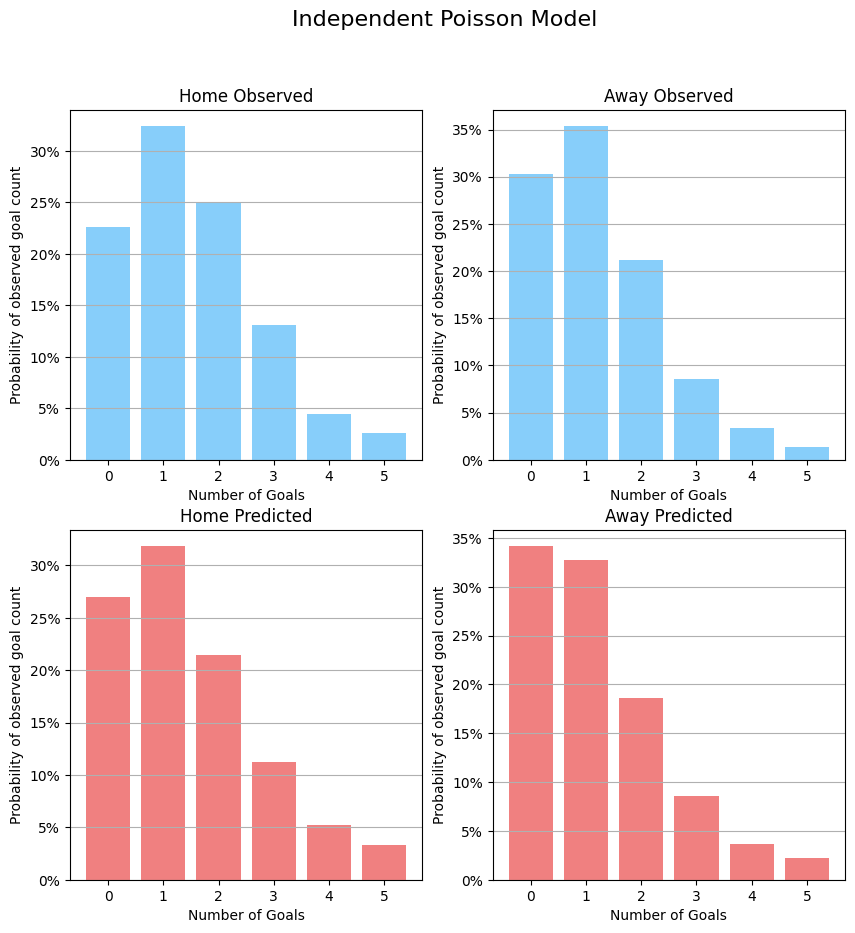

In [16]:
his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.suptitle("Independent Poisson Model", fontsize=16)
ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
ax1[0].set_title("Home Observed")
ax1[0].set_xlabel("Number of Goals")
ax1[0].set_ylabel("Probability of observed goal count")
ax1[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[0].grid(axis="y")

ax2[0].bar(
    np.arange(len(home_cum_hist)),
    home_cum_hist / np.sum(home_cum_hist),
    color="lightcoral",
)
ax2[0].set_title("Home Predicted")
ax2[0].set_xlabel("Number of Goals")
ax2[0].set_ylabel("Probability of observed goal count")
ax2[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[0].grid(axis="y")

ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
ax1[1].set_title("Away Observed")
ax1[1].set_xlabel("Number of Goals")
ax1[1].set_ylabel("Probability of observed goal count")
ax1[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[1].grid(axis="y")

ax2[1].bar(
    np.arange(len(away_cum_hist)),
    away_cum_hist / np.sum(away_cum_hist),
    color="lightcoral",
)
ax2[1].set_title("Away Predicted")
ax2[1].set_xlabel("Number of Goals")
ax2[1].set_ylabel("Probability of observed goal count")
ax2[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[1].grid(axis="y")

In [17]:
print("observed")
print(np.mean(train_data.home_score))
print(np.mean(train_data.away_score))

observed
1.5348569549490299
1.2387372574810918


In [18]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

1.457278038999658
1.2160056684897356


Text(0.5, 1.0, 'Predicted')

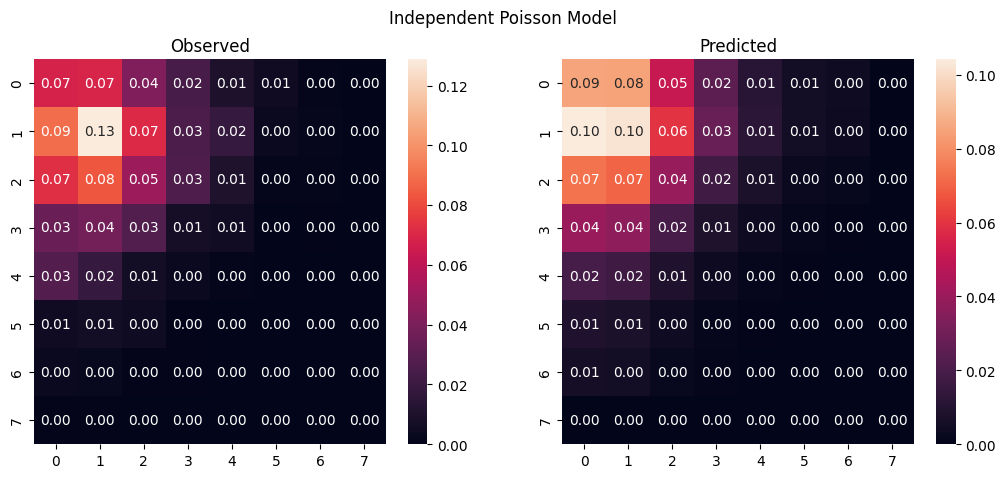

In [19]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size

# predicted
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    probs = probs
    res_table_p += probs

res_table_p = res_table_p / test_data_orig_size

# sb.heatmap(res_table_p, annot=True)

# top pred result:
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_pr = np.array([np.zeros(max_goals) for _ in range(max_goals)])

game_quotes = []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    res_table_pr[np.argmax(home_hist)][np.argmax(away_hist)] += 1
res_table_pr = res_table_pr / test_data_orig_size
# sb.heatmap(res_table_pr, annot=True)

fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
fig.suptitle("Independent Poisson Model")
sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
axes[0].set_title("Observed")
sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
axes[1].set_title("Predicted")

In [20]:
print(np.tril(res_table_a).sum() - np.trace(res_table_a))
print(np.trace(res_table_a))
print(np.triu(res_table_a).sum() - np.trace(res_table_a))

0.4278317152103559
0.25501618122977343
0.31715210355987045


In [21]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

0.4310528990291265
0.2368428420711975
0.3254187126213594


In [22]:
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table += probs


# for x in range(len(res_table)):
#     for y in range(len(res_table[x])):
#         if x == y:
#             res_table[x][y] *= 1.2
#         else:
#             res_table[x][y] *= 0.95

# res_table = res_table / test_data_orig_size
# print(sum(sum(res_table)))
# sb.heatmap(res_table, annot=True)

In [23]:
df_cross

,actual,pred,pred_val,bookie,bookie_val
0,1,0,0.578,2,37.290950
1,0,0,0.404,0,62.975779
2,0,0,0.683,2,50.000000
3,0,0,0.752,0,81.810744
4,2,0,0.363,0,52.927174
...,...,...,...,...,...
1540,2,2,0.779,2,62.263129
1541,0,0,0.614,0,83.160083
1542,2,2,0.450,2,65.430464
1543,1,0,0.432,2,54.500255


In [24]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
0.2792071938399472
-0.3410958564514225
0.11613788130093028


In [25]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 835
won: 420
lost: 415
money:  4809.9


In [26]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 484
won: 386
lost: 98
money:  2346.5000000000023


In [27]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 1042
won: 591
lost: 451
money:  5093.7000000000035


# Inflated Diagonal

In [28]:
print(np.trace(res_table_a) / np.trace(res_table_p))
print(np.trace(res_table_a) / (np.trace(res_table_p) * (np.trace(res_table_a) / np.trace(res_table_p))))


print((np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / 
      ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)) * 
       (np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / 
      ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)))))

1.0767316377377065
1.0
1.0


In [29]:
mult_diagonal = (np.trace(res_table_a) / np.trace(res_table_p))
mult_rest =  (np.tril(res_table_a).sum() - np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)) / ((np.tril(res_table_p).sum() - np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)))

In [30]:
home_std = np.std(predictions_home, axis=1)
away_std = np.std(predictions_away, axis=1)
print(f"Home std: {home_std.mean()}, Away std: {away_std.mean()}, Overall std: {(home_std.mean() + away_std.mean()) / 2}")

Home std: 1.2025039096102332, Away std: 1.087769566834607, Overall std: 1.14513673822242


In [31]:
all_probs = []
game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6, 7]
    )
    if home_hist.shape[0] < max_goals:
        home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
    if away_hist.shape[0] < max_goals:
        away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))
    home_hist = home_hist / 1000
    away_hist = away_hist / 1000
    probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
    for x in range(len(probs)):
        for y in range(len(probs[x])):
            if x == y:
                probs[x][y] *= 1.3
            else:
                probs[x][y] *= 1 - 0.085
            # if x == y:
            #     probs[x][y] *= mult_diagonal
            # else:
            #     probs[x][y] *= mult_rest
    all_probs.append(np.array(probs))
    home = np.tril(probs).sum() - np.trace(probs)
    draw = np.trace(probs)
    away = np.triu(probs).sum() - np.trace(probs)
    game_quotes.append(f"{home}-{draw}-{away}")
    most_goals["home"].append(
        f"h: {np.argmax(home_hist)} - {round(np.max(home_hist)/10)}%"
    )
    most_goals["away"].append(
        f"a: {np.argmax(away_hist)} - {round(np.max(away_hist)/10)}%"
    )

df_res = pd.DataFrame(
    {
        "actual": act_res,
        "predicted": game_quotes,
        "prob goals home": most_goals["home"],
        "prob goals away": most_goals["away"],
    }
)
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[x]["actual"].split(":")[0])
            > int(df_res.iloc[x]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[x]["actual"].split(":")[0])
            == int(df_res.iloc[x]["actual"].split(":")[1])
            else 2
            for x in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[x]["predicted"].split("-")])
            for x in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[x].bookie_home,
                    test_data.iloc[x].bookie_draw,
                    test_data.iloc[x].bookie_away,
                ]
            )
            for x in range(test_data_orig_size)
        ],
    }
)

In [32]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['actual'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['actual'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['actual'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

Verteilung:
Anzahl Predicted Home: 792 (51.26%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 296 (19.16%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 457 (29.58%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 869 (56.25%), Anzahl Falsch: 676 (43.75%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 488 (73.83%), Anzahl Home Falsch: 304
Home Pred. aber Draw --> 173
Home Pred. aber Away --> 131
Anzahl Draw Korrekt: 109 (27.66%), Anzahl Draw Falsch: 187
Draw Pred. aber Home --> 100
Draw Pred. aber Away --> 87
Anzahl Away Korrekt: 272 (55.51%), Anzahl Away Falsch: 185
Away Pred. aber Home --> 73
Away Pred. aber Draw --> 112


In [33]:
h = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,0]
d = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,1]
a = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,2]

print(np.mean(h))
print(np.mean(d))
print(np.mean(a))

0.39441340261165053
0.3078956946925566
0.2977581220485437


In [34]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        predictions_home[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        predictions_away[game_idx], [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

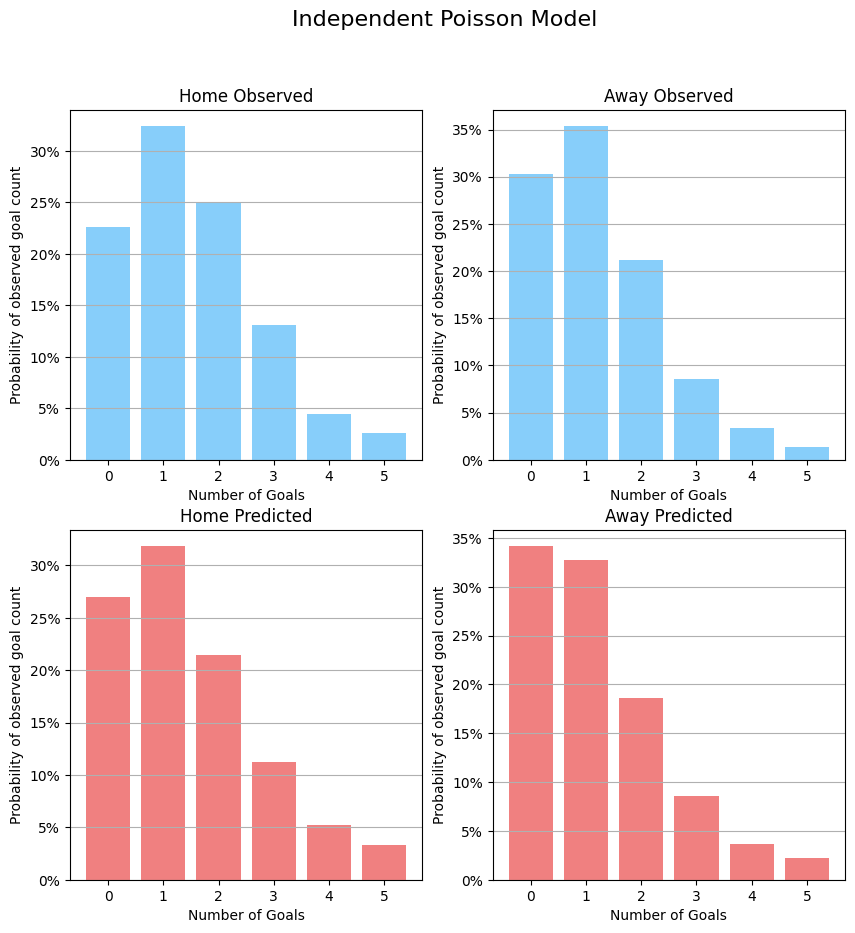

In [35]:
his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
fig, (ax1, ax2) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.suptitle("Independent Poisson Model", fontsize=16)
ax1[0].bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
ax1[0].set_title("Home Observed")
ax1[0].set_xlabel("Number of Goals")
ax1[0].set_ylabel("Probability of observed goal count")
ax1[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[0].grid(axis="y")

ax2[0].bar(
    np.arange(len(home_cum_hist)),
    home_cum_hist / np.sum(home_cum_hist),
    color="lightcoral",
)
ax2[0].set_title("Home Predicted")
ax2[0].set_xlabel("Number of Goals")
ax2[0].set_ylabel("Probability of observed goal count")
ax2[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[0].grid(axis="y")

ax1[1].bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
ax1[1].set_title("Away Observed")
ax1[1].set_xlabel("Number of Goals")
ax1[1].set_ylabel("Probability of observed goal count")
ax1[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax1[1].grid(axis="y")

ax2[1].bar(
    np.arange(len(away_cum_hist)),
    away_cum_hist / np.sum(away_cum_hist),
    color="lightcoral",
)
ax2[1].set_title("Away Predicted")
ax2[1].set_xlabel("Number of Goals")
ax2[1].set_ylabel("Probability of observed goal count")
ax2[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
)
ax2[1].grid(axis="y")

In [36]:
print(np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist))
print(np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist))

1.457278038999658
1.2160056684897356


In [37]:
res_table_p = np.array([sum(x) for x in zip(*all_probs)])
res_table_p.shape
res_table_p = res_table_p / test_data_orig_size

Text(0.5, 25.722222222222214, 'Away Goals')

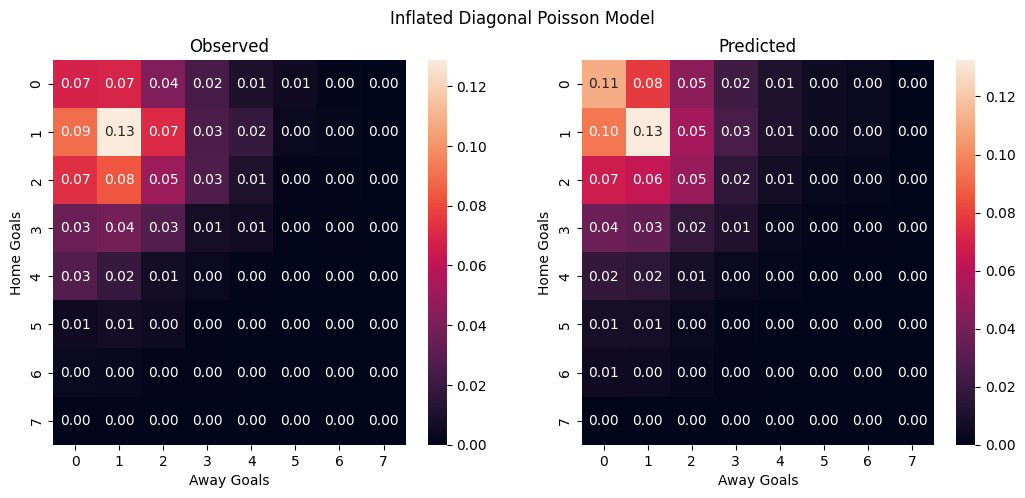

In [38]:
# actual
max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
for h, a in zip(actual_home, actual_away):
    res_table_a[int(h)][int(a)] += 1
res_table_a = res_table_a / test_data_orig_size

# predicted
# max_goals = int(np.max([np.max(actual_home), np.max(actual_away)])) + 1
# res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

# game_quotes = []
# for game_idx in range(len(predictions_home)):
#     home_hist, bin_edges = np.histogram(predictions_home[game_idx], [0,1,2,3,4,5,6,7])
#     away_hist, bin_edges = np.histogram(predictions_away[game_idx], [0,1,2,3,4,5,6,7])
#     if home_hist.shape[0] < max_goals:
#         home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
#     if away_hist.shape[0] < max_goals:
#         away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

#     home_hist = home_hist / 1000
#     away_hist = away_hist / 1000
#     probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
#     probs = probs
#     res_table_p += probs

# res_table_p = res_table_p / test_data_orig_size


fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))
fig.suptitle("Inflated Diagonal Poisson Model")
sb.heatmap(ax=axes[0], data=res_table_a, annot=True, fmt=".2f")
axes[0].set_title("Observed")
axes[0].set_ylabel("Home Goals")
axes[0].set_xlabel("Away Goals")
sb.heatmap(ax=axes[1], data=res_table_p, annot=True, fmt=".2f")
axes[1].set_title("Predicted")
axes[1].set_ylabel("Home Goals")
axes[1].set_xlabel("Away Goals")

In [39]:
print(np.tril(res_table_p).sum() - np.trace(res_table_p))
print(np.trace(res_table_p))
print(np.triu(res_table_p).sum() - np.trace(res_table_p))

print(
    np.sum(
        [
            np.tril(res_table_p).sum() - np.trace(res_table_p),
            np.trace(res_table_p),
            np.triu(res_table_p).sum() - np.trace(res_table_p),
        ]
    )
)

0.39441340261165037
0.3078956946925565
0.2977581220485438
1.0000672193527507


In [40]:
# ece
data_length = df_cross.shape[0]

# acc_model = np.sum(df_cross['actual'] == df_cross['pred']) / data_length
# acc_bookie = np.sum(df_cross['bookie'] == df_cross['actual']) / data_length

# print("Accuracy Model: ", acc_model)
# print("Accuracy Bookie: ", acc_bookie)

# conf_model = np.sum(df_cross['pred_val']) / data_length
# conf_bookie = np.sum(df_cross['bookie_val']/100) / data_length

# print("Confidence Model: ", conf_model)
# print("Confidence Bookie: ", conf_bookie)

# ece_model = np.mean(np.absolute(acc_model - conf_model))
# ece_bookie = np.mean(np.absolute(acc_bookie - conf_bookie))

# print(f"Model ECE: {ece_model}")
# print(f"Bookie ECE: {ece_bookie}")
acc_home = (
    df_cross.loc[(df_cross["bookie"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["bookie"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["bookie"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["bookie"] == 0)].bookie_val / 100)
conf_draw = np.mean(df_cross.loc[(df_cross["bookie"] == 1)].bookie_val / 100)
conf_away = np.mean(df_cross.loc[(df_cross["bookie"] == 2)].bookie_val / 100)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)


acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(acc_home - conf_home)
print(acc_draw - conf_draw)
print(acc_away - conf_away)

0.2601783491155203
nan
0.06721056586652263
0.19991398647288894
-0.15071413792872823
0.03476240361720184


In [41]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 1054
won: 462
lost: 592
money:  5411.4


In [42]:
bet_threshold = 60
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) >= bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) >= bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) >= bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 381
# won: 319
# lost: 62
# money:  2066.035947551149

bets: 351
won: 295
lost: 56
money:  1731.4999999999993


In [43]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold or (float(pred_h) * 100) >= 60:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold or (float(pred_d) * 100) >= 60:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold or (float(pred_a) * 100) >= 60:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1206
# won: 640
# lost: 566
# money:  7222.5381890291965

bets: 1228
won: 614
lost: 614
money:  5743.600000000003


In [44]:
df_cross

,actual,pred,pred_val,bookie,bookie_val
0,1,0,0.531871,2,37.290950
1,0,1,0.403811,0,62.975779
2,0,0,0.629913,2,50.000000
3,0,0,0.700656,0,81.810744
4,2,1,0.376460,0,52.927174
...,...,...,...,...,...
1540,2,2,0.727475,2,62.263129
1541,0,0,0.562985,0,83.160083
1542,2,2,0.413327,2,65.430464
1543,1,0,0.395743,2,54.500255
